In [14]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("white")

pandas2ri.activate()

In [3]:
data_file = "data/CHGdataSIMPA.txt"
basin_file = "data/CHGbasins.txt"

In [4]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('exec_optim_semidist.R')

# Loading the function we have defined in R.
robjects.globalenv['init_global'](data_file, basin_file)
exec_function_r = robjects.globalenv['eval_basin_param']
get_basin_q = robjects.globalenv['get_basin_q']

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: hydroGOF

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

R[write to console]: Please note that 'maptools' will be retired during October 2023,
plan transition at your earliest convenience (see
https://r-spatial.org/r/2023/05/15/evolution4.html and earlier blogs
for guidance);some functionality will be moved to 'sp'.
 Checking rgeos availability: FALSE



Rows: 5 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
result_path = "results/new_data/"
problem_type = "full_eqw_5043"

result_files = [
    (f"./{result_path}config_{problem_type}_0_MSE.csv",0,"MSE"),
    (f"./{result_path}config_{problem_type}_1_MSE.csv",1,"MSE"),
    (f"./{result_path}config_{problem_type}_2_MSE.csv",2,"MSE"),
    (f"./{result_path}config_{problem_type}_3_MSE.csv",3,"MSE"),
    (f"./{result_path}config_{problem_type}_0_NSE.csv",0,"NSE"),
    (f"./{result_path}config_{problem_type}_1_NSE.csv",1,"NSE"),
    (f"./{result_path}config_{problem_type}_2_NSE.csv",2,"NSE"),
    (f"./{result_path}config_{problem_type}_3_NSE.csv",3,"NSE"),
    (f"./{result_path}config_{problem_type}_0_R2.csv",0,"R2"),
    (f"./{result_path}config_{problem_type}_1_R2.csv",1,"R2"),
    (f"./{result_path}config_{problem_type}_2_R2.csv",2,"R2"),
    (f"./{result_path}config_{problem_type}_3_R2.csv",3,"R2"),
    (f"./{result_path}config_{problem_type}_0_KGE.csv",0,"KGE"),
    (f"./{result_path}config_{problem_type}_1_KGE.csv",1,"KGE"),
    (f"./{result_path}config_{problem_type}_2_KGE.csv",2,"KGE"),
    (f"./{result_path}config_{problem_type}_3_KGE.csv",3,"KGE"),
]

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")

./results/new_data/config_full_eqw_5043_0_MSE.csv Yes
./results/new_data/config_full_eqw_5043_1_MSE.csv Yes
./results/new_data/config_full_eqw_5043_2_MSE.csv Yes
./results/new_data/config_full_eqw_5043_3_MSE.csv Yes
./results/new_data/config_full_eqw_5043_0_NSE.csv Yes
./results/new_data/config_full_eqw_5043_1_NSE.csv Yes
./results/new_data/config_full_eqw_5043_2_NSE.csv Yes
./results/new_data/config_full_eqw_5043_3_NSE.csv Yes
./results/new_data/config_full_eqw_5043_0_R2.csv Yes
./results/new_data/config_full_eqw_5043_1_R2.csv Yes
./results/new_data/config_full_eqw_5043_2_R2.csv Yes
./results/new_data/config_full_eqw_5043_3_R2.csv Yes
./results/new_data/config_full_eqw_5043_0_KGE.csv Yes
./results/new_data/config_full_eqw_5043_1_KGE.csv Yes
./results/new_data/config_full_eqw_5043_2_KGE.csv Yes
./results/new_data/config_full_eqw_5043_3_KGE.csv Yes


In [6]:
agg_q = {}
result_q = {}

basin_df = pd.read_csv("data/CHGbasins.txt")
basin_df.sort_values(by=["order"])

eval_df = pd.DataFrame(columns=["model", "target", "basin_idx", "MSE", "RMSE", "Pbias", "NSE", "R2", "KGE", "params"])

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if os.path.exists(file_name):
        params = np.loadtxt(file_name, delimiter=",", max_rows=1).reshape([len(basin_df),-1])

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]
            
            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]
            
            if codedown not in agg_q:
                agg_q[codedown] = 0
            
            agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            param_str = np.array2string(params[idx], max_line_width=np.inf, separator=";").replace(" ", "")
            eval_df.loc[len(eval_df)] = [model, target, basin_code] + list(metrics) + [param_str]

eval_df = eval_df[eval_df["target"] != "R2"]
eval_df    

./results/new_data/config_full_eqw_5043_0_MSE.csv Yes
./results/new_data/config_full_eqw_5043_1_MSE.csv Yes
./results/new_data/config_full_eqw_5043_2_MSE.csv Yes
./results/new_data/config_full_eqw_5043_3_MSE.csv Yes
./results/new_data/config_full_eqw_5043_0_NSE.csv Yes
./results/new_data/config_full_eqw_5043_1_NSE.csv Yes
./results/new_data/config_full_eqw_5043_2_NSE.csv Yes
./results/new_data/config_full_eqw_5043_3_NSE.csv Yes
./results/new_data/config_full_eqw_5043_0_R2.csv Yes
./results/new_data/config_full_eqw_5043_1_R2.csv Yes
./results/new_data/config_full_eqw_5043_2_R2.csv Yes
./results/new_data/config_full_eqw_5043_3_R2.csv Yes
./results/new_data/config_full_eqw_5043_0_KGE.csv Yes
./results/new_data/config_full_eqw_5043_1_KGE.csv Yes
./results/new_data/config_full_eqw_5043_2_KGE.csv Yes
./results/new_data/config_full_eqw_5043_3_KGE.csv Yes


,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
0,0,MSE,5029,24.593764,4.959210,-27.2,0.468904,0.592196,0.420575,[9.75326477e-01;6.33514558e+02;5.89106798e-01;...
1,0,MSE,5054,7.409530,2.722045,2290.9,-42.403926,0.225320,-22.026578,[3.76784108e-01;1.38181718e+03;3.08829731e-01;...
2,0,MSE,5060,13.331136,3.651183,155.6,-1.343549,0.699827,-0.601046,[8.72022034e-01;1.88301600e+03;1.38959384e-01;...
3,0,MSE,5071,6.648384,2.578446,-6.6,0.811870,0.826267,0.777976,[7.43787502e-01;1.18565079e+03;9.69205379e-01;...
4,0,MSE,5043,3250.133717,57.009944,230.2,-17.085949,0.453572,-1.986778,[4.71866795e-01;1.34591789e+03;6.16248654e-01;...
5,1,MSE,5029,24.593973,4.959231,-27.2,0.468899,0.592175,0.420577,[9.75326767e-01;6.33418383e+02;5.89219197e-01;...
6,1,MSE,5054,8.290569,2.879335,2417.4,-47.564921,0.235590,-23.306803,[1.50827984e-02;1.39647939e+03;5.62381635e-02;...
7,1,MSE,5060,31.629544,5.624015,216.3,-4.560319,0.792506,-1.508729,[2.26995991e-01;8.27526810e+02;5.43910439e-01;...
8,1,MSE,5071,16.993911,4.122367,-47.7,0.519122,0.848705,0.369601,[0.52894532;370.5401995;0.76119066;6.33660284;...
9,1,MSE,5043,4288.826481,65.489133,262.5,-22.865940,0.398781,-2.464721,[2.97926883e-02;1.42504732e+03;6.40143723e-03;...


In [7]:
eval_df[eval_df["target"] == "NSE"]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
20,0,NSE,5029,24.746316,4.974567,-37.4,0.465610,0.636954,0.423729,[9.94920338e-01;4.68435278e+02;5.90352183e-01;...
21,0,NSE,5054,7.839029,2.799827,2217.5,-44.919863,0.260127,-21.388941,[2.40056820e-01;6.70705499e+02;7.45671896e-01;...
22,0,NSE,5060,43.195319,6.572315,224.5,-6.593526,0.733212,-1.852280,[4.17238131e-02;4.08693361e+02;8.28718977e-01;...
23,0,NSE,5071,6.834668,2.614320,16.2,0.806599,0.835811,0.766831,[1.70446244e-01;1.83255601e+03;8.27604623e-01;...
24,0,NSE,5043,2952.279593,54.334884,212.0,-15.428487,0.444052,-1.883230,[6.24197579e-01;1.17707243e+03;9.98110607e-01;...
25,1,NSE,5029,24.746216,4.974557,-37.4,0.465612,0.636970,0.423745,[9.94920199e-01;4.68505339e+02;5.90240606e-01;...
26,1,NSE,5054,4.710583,2.170388,1577.7,-26.593893,0.261656,-15.017775,[2.38802377e-01;3.36095010e+02;9.98259564e-01;...
27,1,NSE,5060,43.170100,6.570396,198.2,-6.589093,0.484213,-1.653126,[0.32653811;10.;0.71467768;12.69012337;0.65684...
28,1,NSE,5071,9.182585,3.030278,-17.0,0.740160,0.774878,0.788252,[3.55606193e-02;2.52371551e+02;4.74279201e-01;...
29,1,NSE,5043,748.445960,27.357740,45.9,-3.164861,0.155371,-0.314120,[0.37741539;10.;0.90886839;2.95029992;0.124993...


In [14]:
eval_df[eval_df["basin_idx"] == 5043]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
4,0,MSE,5043,3250.133717,57.009944,230.2,-17.085949,0.453572,-1.986778,[0.4718667949866753;1345.9178876407045;0.61624...
9,1,MSE,5043,4288.826481,65.489133,262.5,-22.865940,0.398781,-2.464721,[0.02979268833455609;1425.0473214487442;0.0064...
14,2,MSE,5043,100.383078,10.019136,-4.7,0.441400,0.448469,0.558206,[0.25524113149402117;1856.3588160373456;0.8186...
19,3,MSE,5043,535.775678,23.146829,89.7,-1.981419,0.398453,-0.016306,[0.9152713953372027;1895.6863115958756;0.93038...
24,0,NSE,5043,2952.279593,54.334884,212.0,-15.428487,0.444052,-1.883230,[0.6241975788335028;1177.0724307843316;0.99811...
29,1,NSE,5043,748.445960,27.357740,45.9,-3.164861,0.155371,-0.314120,[0.3774153880526602;10.0;0.9088683925318071;2....
34,2,NSE,5043,1695.516519,41.176650,158.7,-8.435004,0.409111,-1.092787,[0.34834327562642453;1431.494162381971;0.87364...
39,3,NSE,5043,3253.024817,57.035294,208.8,-17.102037,0.363819,-2.097079,[0.07593372875956185;811.5156807081728;0.41770...
44,0,R2,5043,1137.234744,33.722911,129.5,-5.328346,0.487593,-0.687574,[0.91101449224623;1663.7061714739475;0.7490864...
49,1,R2,5043,335.873664,18.326856,44.7,-0.869029,0.409925,0.215515,[0.32663280750993096;1777.9277805110098;0.6728...


In [8]:
eval_df.to_csv(f"{problem_type}_table.txt", index=False, quoting=csv.QUOTE_NONE)

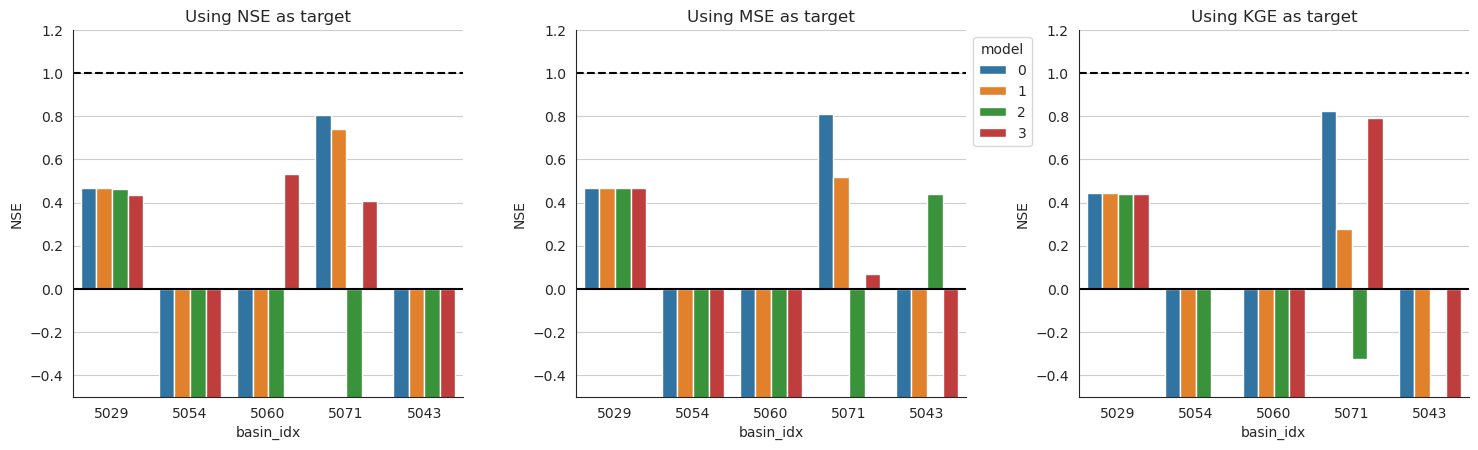

In [16]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))


metric_measure = "NSE"
for idx, metric in enumerate(["NSE", "MSE", "KGE"]):    
    # ax = axes[idx//2, idx%2]
    ax = axes[idx]

    fig.tight_layout(h_pad=2)
    plt.subplots_adjust(top=0.85)

    data_to_plot = eval_df[eval_df["target"] == metric][['basin_idx', 'model', metric_measure]]
    hist_ax = sns.barplot(data=data_to_plot, x="basin_idx", y=metric_measure, hue="model", ax=ax, order=basin_df["code"])
    hist_ax.set(title = f"Using {metric} as target")


    if idx == 1:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()
    

    if metric_measure not in ["MSE", "RMSE", "Pbias"]:
        ax.axhline(1, color="k", linestyle="--")
        if metric == "R2" and metric_measure in ["NSE", "KGE"]:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
        else:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
    

    if metric_measure == "Pbias":
        hist_ax.set(ylim = [-150, 750])#, yticks = range(-25,30,5))
        ax.axhline(0, color="k")
    
    sns.despine()
    ax.grid(axis="y")

plt.show()